L-prostor - cvorovi su stajalista, a grane postoje izmedju susednih stajalista

Ucitavanje fajla stops.txt (stajalista) - pa za njih formiram cvorove; Potrebno je na svakoj okretnici povezati stajalista da bi putnik mogao da promeni liniju kojom se vozi - za to mi trebaju sva grupisana stajalista po stopName, pa se prave kombinacije - gde postoje, a postoje samo na okretnicama. Dakle, izmedju njih se dodaju grane. Zatim se ucitava fajl tripStopTimes i tu se grupise po liniji i spajaju se susedne stanice.

In [56]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# neusmeren beztezinski graf
G = nx.Graph()

# KREIRANJE CVOROVA
stopsPath = "../Desktop/asmPodaci/stops.txt"
stops = pd.read_csv(stopsPath)

for stop in stops.itertuples(index=False):
    stop_id = stop.stop_id
    stop_name = stop.stop_name
    stop_lat = stop.stop_lat
    stop_lon = stop.stop_lon
    zone_id = stop.zone_id
    G.add_node(stop_id, name=stop_name, lat=stop_lat, lon=stop_lon, zone=zone_id)

    
# KREIRANJE GRANA
tripStopTimesPath = "../Desktop/sredjeniPodaci/tripStopTimes.txt"
tripStopTimes = pd.read_csv(tripStopTimesPath, sep='\t')

# 1) IZBACIVANJE NOCNIH LINIJA
# Ovde sam radila analizu svih linija koje polaze posle 24:00 da bih videla na koji nacin da izbacim nocni rezim linija
# prvo sam htela na ovaj nacin ispod da izbacim nocni rezim, medjutim neke linije iz dnevnog rezima imaju polaske u 24:00
# polasci = tripStopTimes[((tripStopTimes['stop_sequence'] == 1) & (tripStopTimes['arrival_time'].str.startswith(('24:', '25:', '26:', '27:', '28:'))))]
# polasci.to_csv("polasci.txt", sep='\t')

# prethodnom analizom sam zakljucila da sve nocne linije pocinju sa 50, 51, 52 ili 53 i posle imaju vrednost vecu od 15
# izbacujem nocne linije jer se u zadatku trazi ispitivanje za dnevni rezim
tripStopTimes = tripStopTimes[~(((tripStopTimes['route_id'].astype(str).str.startswith('50')) & (tripStopTimes['route_id'] >= 50015)) |
                    ((tripStopTimes['route_id'].astype(str).str.startswith('51')) & (tripStopTimes['route_id'] >= 51015)) |
                    ((tripStopTimes['route_id'].astype(str).str.startswith('52')) & (tripStopTimes['route_id'] >= 52015)) |
                    ((tripStopTimes['route_id'].astype(str).str.startswith('53')) & (tripStopTimes['route_id'] >= 53015)))]

# 2) Dodavanje grana između krajnje tacke jednog smera sa pocetnom tackom drugog smera
def merge_endpoints(group):
    min_stop = group[group['stop_sequence'] == group['stop_sequence'].min()]['stop_id'].values[0]
    max_stop = group[group['stop_sequence'] == group['stop_sequence'].max()]['stop_id'].values[0]
    return min_stop, max_stop

for route_id, group in tripStopTimes.groupby('route_id'):
    # neke linije nemaju dva smera
    if len(group['direction_id'].unique()) == 2:
        minMaxDirZero = merge_endpoints(group[group['direction_id'] == 0])  # pocetna i krajnja tacka prvog smera
        minMaxDirOne = merge_endpoints(group[group['direction_id'] == 1])  # pocetna i krajnja tacka drugog smera
        if(minMaxDirZero[0] != minMaxDirOne[1]):
            G.add_edge(minMaxDirZero[0], minMaxDirOne[1])
        if(minMaxDirZero[1] != minMaxDirOne[0]):
            G.add_edge(minMaxDirZero[1], minMaxDirOne[0])
            
# postoje stop_id koji su NaN, pa te vrednosti izbacujem, da se ne bi stvarali dodatni cvorovi
tripStopTimes = tripStopTimes.dropna(subset=['stop_id'])

# OVO IPAK NE jer je receno u zadatku da skup stajalista moze varirati u zavisnosti od polazaka linije
# tripStopTimes = tripStopTimes.drop_duplicates(subset=['route_id','stop_id'])

# sortiram po trip_id i stop_sequence
tripStopTimesSorted = tripStopTimes.sort_values(by=['trip_id', 'stop_sequence'])

# dodajem kolonu 'next_stop_id' sa sledecim stop_id
tripStopTimesSorted['next_stop_id'] = tripStopTimesSorted.groupby(['trip_id', 'route_id'])['stop_id'].shift(-1)

# Filtriranje i izbacivanje NaN vrednosti
filtered_data = tripStopTimesSorted.dropna(subset=['next_stop_id'])

# Konverzija podataka u listu tuplova
edges = list(filtered_data[['stop_id', 'next_stop_id']].itertuples(index=False, name=None))

# Dodavanje grana u graf
G.add_edges_from(edges)


In [57]:
print("Broj čvorova (stajališta):", G.number_of_nodes())
print("Broj grana:", G.number_of_edges())

# Pronalaženje čvorova sa self loop
nodes_with_selfloops = [node for node in G.nodes if G.has_edge(node, node)]

# Ispisivanje čvorova sa self loop
print("Čvorovi sa self loop:")
for node in nodes_with_selfloops:
    print(node)

Broj čvorova (stajališta): 3130
Broj grana: 3856
Čvorovi sa self loop:


In [58]:
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

Br povezanih komponenti:  7
Velicine povezanih komp:  [3124, 1, 1, 1, 1, 1, 1]


In [59]:
# zbog uklanjanja nocnih linija javlja se da su neku cvorovi bez grana, pa ih onda uklanjam jer su bespotrebni
nodes_to_remove = [1243, 1245, 1247, 3735, 3737, 3757]
G.remove_nodes_from(nodes_to_remove)

# PROVERAVAM OPET DA LI IMA NEPOVEZANIH KOMPONENTI
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

print("Broj čvorova (stajališta):", G.number_of_nodes())
print("Broj grana:", G.number_of_edges())

Br povezanih komponenti:  1
Velicine povezanih komp:  [3124]
Broj čvorova (stajališta): 3124
Broj grana: 3856


In [60]:
numOfNodes = G.number_of_nodes()
numOfEdges = G.number_of_edges()

density = 2 * numOfEdges / (numOfNodes * (numOfNodes - 1))

print("Gustina L mreze:", density)

Gustina L mreze: 0.0007904674868996823


In [30]:
averageDistance = nx.average_shortest_path_length(G)
diameter = nx.diameter(G)

print("Prosecna distanca:", averageDistance)
print("Dijametar:", diameter)

Prosecna distanca: 27.245872287841685
Dijametar: 104


In [32]:
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

# provera postojanja gigantske komp
hasGiantComponent = max(sizeOfConnectedComponents) > 1
print("Postoji gigantska komp: ", hasGiantComponent)

# izracunavanje centralizacije
max_degree = max(dict(G.degree()).values()) # sadrzi cvorove kao kljuceve i njihov stepen kao vrednost
centralization = (sum([max_degree - degree for degree in dict(G.degree()).values()])) / ((len(G) - 1) * (len(G) - 2))
print("Centralizacija:", centralization)

Br povezanih komponenti:  1
Velicine povezanih komp:  [3124]
Postoji gigantska komp:  True
Centralizacija: 0.001772306601657476


Prosečni koef klasterizacije: 0.014310103042497413
Globalni koef klasterizacije: 0.028730703259005147


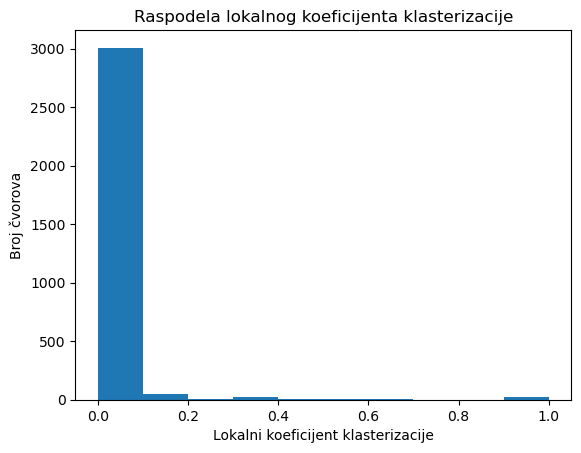

Prosečni koeficijent klasterizacije (Erdos-Renyi): 0.200082390872235
Prosečni koeficijent klasterizacije (Scale-free): 0.008857675831847106


In [33]:
averageClusteringCoef = nx.average_clustering(G)
globalClusteringCoef = nx.transitivity(G) # compute graph transitivity, the fraction of all possible triangles present in G

print("Prosečni koef klasterizacije:", averageClusteringCoef)
print("Globalni koef klasterizacije:", globalClusteringCoef)

localClusteringCoeffs = nx.clustering(G)
plt.hist(list(localClusteringCoeffs.values()), bins=10)
plt.xlabel('Lokalni koeficijent klasterizacije')
plt.ylabel('Broj čvorova')
plt.title('Raspodela lokalnog koeficijenta klasterizacije')
plt.show()

# Generisanje Erdos-Renyi mreže
erdosRenyiGraph = nx.erdos_renyi_graph(n=len(G.nodes), p=0.2)
erdosRenyiAvgClustering = nx.average_clustering(erdosRenyiGraph)

# Generisanje scale-free mreže
scaleFreeGraph = nx.barabasi_albert_graph(n=len(G.nodes), m=2)
scaleFreeAvgClustering = nx.average_clustering(scaleFreeGraph)

print("Prosečni koeficijent klasterizacije (Erdos-Renyi):", erdosRenyiAvgClustering)
print("Prosečni koeficijent klasterizacije (Scale-free):", scaleFreeAvgClustering)

In [34]:
# izracunavanje koef asortativnosti
assortativity = nx.degree_assortativity_coefficient(G)
print("Koeficijent asortativnosti:", assortativity)

output_path = "../Desktop/asmPodaci/Lgraph.gml"

nx.write_gml(G, output_path)

Koeficijent asortativnosti: 0.29106927932351206


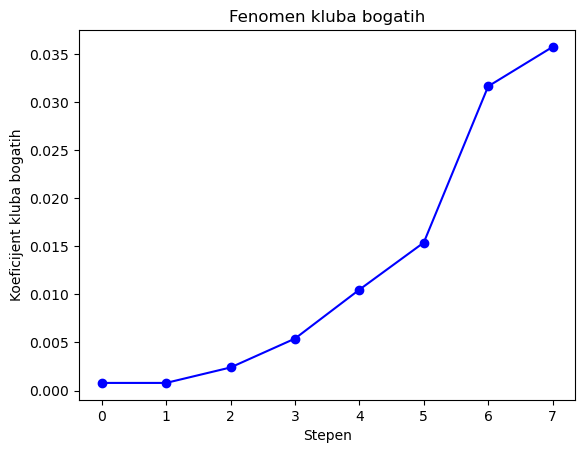

Mreža ne ispoljava rich club phenomenon.


In [35]:
richClubCoeffs = nx.rich_club_coefficient(G, normalized=False)

plt.plot(list(richClubCoeffs.keys()), list(richClubCoeffs.values()), 'bo-')
plt.xlabel('Stepen')
plt.ylabel('Koeficijent kluba bogatih')
plt.title('Fenomen kluba bogatih')
plt.show()

if max(richClubCoeffs.values()) > 1:
    print("Mreža ispoljava rich club phenomenon.")
else:
    print("Mreža ne ispoljava rich club phenomenon.")

In [37]:
# izbacujem sva stajalista koja koriste samo nocne linije
stops = stops[stops['stop_id'].isin(tripStopTimes['stop_id'])]

# Grupisanje stajališta po tarifnim zonama
grouped_by_zone = stops.groupby('zone_id')

# Prikaz broja stajališta po zonama
print("Broj stajalista po zonama:")
print(grouped_by_zone['stop_id'].count())

Broj stajalista po zonama:
zone_id
1    1220
2    1846
3      58
Name: stop_id, dtype: int64


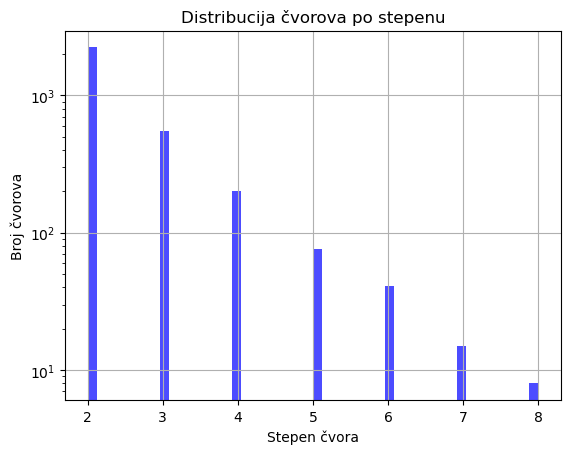

In [38]:
# Izračunavanje distribucije čvorova po stepenu
degree_distribution = dict(G.degree())

# Izračunavanje histograma distribucije čvorova po stepenu
degree_values = list(degree_distribution.values())
plt.hist(degree_values, bins=50, log=True, color='b', alpha=0.7)

# Podešavanje grafičkih elemenata
plt.xlabel('Stepen čvora')
plt.ylabel('Broj čvorova')
plt.title('Distribucija čvorova po stepenu')
plt.grid(True)

# Prikazivanje histograma
plt.show()

In [39]:
# Analiza centralnosti po stepenu
degree_centrality = nx.degree_centrality(G)

# centralnost po bliskosti
closeness_centrality = nx.closeness_centrality(G)

# relacionа centralnost
betweenness_centrality = nx.betweenness_centrality(G)

# Centralnost po stepenu sortirano
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po centralnosti po stepenu:")
print(sorted_degree_centrality[:10])

# Centralnost po bliskosti sortirano
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po centralnosti po bliskosti:")
print(sorted_closeness_centrality[:10])

# Relaciona centralnost sortirano
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po relacionoj centralnosti:")
print(sorted_betweenness_centrality[:10])  # Prikaz prvih 10 najvažnijih aktera

Najvažniji akteri po centralnosti po stepenu:
[(147, 0.002561639449247518), (496, 0.002561639449247518), (503, 0.002561639449247518), (1049, 0.002561639449247518), (1152, 0.002561639449247518), (1153, 0.002561639449247518), (1652, 0.002561639449247518), (1692, 0.002561639449247518), (119, 0.0022414345180915784), (220, 0.0022414345180915784)]
Najvažniji akteri po centralnosti po bliskosti:
[(397, 0.06129899699687911), (398, 0.061148966165413536), (496, 0.06094372024041839), (271, 0.060892623861797335), (493, 0.06086651464655324), (706, 0.060733941385815136), (495, 0.06062076596075082), (494, 0.06037699371677139), (272, 0.06001268279559561), (274, 0.059532206103814406)]
Najvažniji akteri po relacionoj centralnosti:
[(495, 0.1702008429460787), (1652, 0.1389643487318205), (1049, 0.13376281634095097), (397, 0.13287983107660745), (398, 0.13230467166670914), (298, 0.12782037306447863), (392, 0.12595579283493358), (496, 0.11956323929455119), (394, 0.11263001152113576), (1852, 0.110157019381333

In [40]:
# Računanje vrednosti centralnosti po sopstvenom vektoru
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sortiranje
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Prikazivanje najvažnijih čvorova
print("Najvažniji čvorovi po centralnosti po sopstvenom vektoru:")
print(sorted_eigenvector_centrality[:10])

Najvažniji čvorovi po centralnosti po sopstvenom vektoru:
[(496, 0.3381830543282831), (494, 0.282066775637884), (493, 0.2734955200368695), (503, 0.2470115595942514), (495, 0.24309368958343655), (2498, 0.23125718041802046), (274, 0.20862745921172288), (397, 0.1812496213598039), (398, 0.17813167465469257), (706, 0.169213980370213)]


In [41]:
weight_degree = 1
weight_closeness = 0.5
weight_betweenness = 0.8
weight_eigenvector = 0.3

# Izračunavanje kompozitne mere centralnosti za svaki čvor
composite_centrality = {}
for node in G.nodes():
    composite_centrality[node] = (
        weight_degree * degree_centrality[node] +
        weight_closeness * closeness_centrality[node] +
        weight_betweenness * betweenness_centrality[node] +
        weight_eigenvector * eigenvector_centrality[node]
    )

# Sortiranje čvorova
sorted_composite_centrality = sorted(composite_centrality.items(), key=lambda x: x[1], reverse=True)

# Prikazivanje najvažnijih čvorova
print("Najvažniji čvorovi prema kompozitnoj meri centralnosti:")
print(sorted_composite_centrality[:10])

Najvažniji čvorovi prema kompozitnoj meri centralnosti:
[(495, 0.2416405987303609), (496, 0.2301390073035826), (397, 0.19324947935460232), (398, 0.1917789523994175), (1652, 0.1823488267772307), (493, 0.17620892828771995), (494, 0.17388692561910035), (271, 0.15890405044421999), (1653, 0.15658367863579042), (394, 0.14528922458978372)]


In [42]:
output_path = "../Desktop/asmPodaci/Lgraph.gml"

nx.write_gml(G, output_path)

In [77]:
import numpy as np
import networkx as nx

# fja za izracunavanje udaljenosti između geografskih koordinata
def geographic_distance(lat1, lon1, lat2, lon2):
    return ((lat1 - lat2)**2 + (lon1 - lon2)**2)**0.5

# fja za izracunavanje slicnosti stepena cvora (npr. Jaccardova sličnost)
def degree_similarity(graph, node1, node2):
    neighbors1 = set(graph.neighbors(node1)) # uzima skupove svih suseda cvora
    neighbors2 = set(graph.neighbors(node2))
    union = neighbors1.union(neighbors2) # svi susedi od oba cvora (unija)
    intersection = neighbors1.intersection(neighbors2) # zajednиcki susedi ta dva cvora
    if len(union) == 0:
        return 0
    return len(intersection) / len(union) # Jaccardova slicnost - broj zajednickih se podeli sa svim, tj unijom cvorova

# Funkcija za izračunavanje kombinovane sličnosti
def combined_similarity(graph, node1, node2, alpha=0.5):
    lat1, lon1 = graph.nodes[node1]['lat'], graph.nodes[node1]['lon']
    lat2, lon2 = graph.nodes[node2]['lat'], graph.nodes[node2]['lon']
    
    geo_dist = geographic_distance(lat1, lon1, lat2, lon2)
    deg_sim = degree_similarity(graph, node1, node2)
    
    combined_sim = alpha * geo_dist + (1 - alpha) * deg_sim
    return combined_sim

# Izračunavanje matrice sličnosti
num_nodes = len(G.nodes)
similarity_matrix = np.zeros((num_nodes, num_nodes))
node_pair_matrix = [[None] * num_nodes for _ in range(num_nodes)]

# Prolazimo kroz sve parove čvorova i računamo sličnost samo jednom za svaki par
for i, node1 in enumerate(G.nodes):
    for j, node2 in enumerate(G.nodes):
        if i < j:
            similarity = combined_similarity(G, node1, node2)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity # Simetrična matrica
            node_pair_matrix[i][j] = (node1, node2)
            node_pair_matrix[j][i] = (node1, node2)

# Prikaz matrice sličnosti
print(similarity_matrix)

[[0.         0.00108087 0.00089082 ... 0.10702187 0.10574053 0.1059047 ]
 [0.00108087 0.         0.10021762 ... 0.10668696 0.10540975 0.10557138]
 [0.00089082 0.10021762 0.         ... 0.10683821 0.10556036 0.10572237]
 ...
 [0.10702187 0.10668696 0.10683821 ... 0.         0.00134864 0.00112831]
 [0.10574053 0.10540975 0.10556036 ... 0.00134864 0.         0.16697527]
 [0.1059047  0.10557138 0.10572237 ... 0.00112831 0.16697527 0.        ]]


In [62]:
similarity_matrixDF = pd.DataFrame(similarity_matrix)
similarity_matrixDF.to_csv("similarity_matrixL.txt", sep='\t')
node_pair_matrixDF = pd.DataFrame(node_pair_matrix)
node_pair_matrixDF.to_csv("node_pair_matrixL.txt", sep='\t')

In [63]:
# Generisanje Laplasijan matrice
laplacian_matrix = nx.laplacian_matrix(G)
print(laplacian_matrix)
L_array = nx.laplacian_matrix(G).toarray()
print(L_array)
laplacian_matrixDF = pd.DataFrame(laplacian_matrix)
laplacian_matrixDF.to_csv("laplacian_matrixL.txt", sep='\t')

# Pretvaranje Laplasijan matrice u graf Laplasijane
#L_graph = nx.from_scipy_sparse_array(L)
#print(L_graph)
# Iscrtajte graf Laplasijane
#nx.draw(L_graph, with_labels=True, node_color='lightblue', font_weight='bold')
#plt.show()

<class 'networkx.utils.decorators.argmap'> compilation 50:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


  (0, 0)	2
  (0, 1)	-1
  (0, 2)	-1
  (1, 0)	-1
  (1, 1)	3
  (1, 3)	-1
  (1, 40)	-1
  (2, 0)	-1
  (2, 2)	3
  (2, 4)	-1
  (2, 41)	-1
  (3, 1)	-1
  (3, 3)	3
  (3, 5)	-1
  (3, 41)	-1
  (4, 2)	-1
  (4, 4)	3
  (4, 6)	-1
  (4, 40)	-1
  (5, 3)	-1
  (5, 5)	3
  (5, 6)	-1
  (5, 7)	-1
  (6, 4)	-1
  (6, 5)	-1
  :	:
  (3115, 3119)	-1
  (3116, 3022)	-1
  (3116, 3116)	2
  (3116, 3120)	-1
  (3117, 2276)	-1
  (3117, 3021)	-1
  (3117, 3117)	2
  (3118, 2278)	-1
  (3118, 3022)	-1
  (3118, 3118)	2
  (3119, 3113)	-1
  (3119, 3115)	-1
  (3119, 3119)	2
  (3120, 3114)	-1
  (3120, 3116)	-1
  (3120, 3120)	2
  (3121, 3121)	2
  (3121, 3122)	-1
  (3121, 3123)	-1
  (3122, 3113)	-1
  (3122, 3121)	-1
  (3122, 3122)	2
  (3123, 3114)	-1
  (3123, 3121)	-1
  (3123, 3123)	2
[[ 2 -1 -1 ...  0  0  0]
 [-1  3  0 ...  0  0  0]
 [-1  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  2 -1 -1]
 [ 0  0  0 ... -1  2  0]
 [ 0  0  0 ... -1  0  2]]


In [64]:
from scipy.linalg import eigh

eigenvalues, eigenvectors = np.linalg.eig(L_array)
#eigenvalues, eigenvectors = eigh(L_array)

In [47]:
sorted_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Prikaz rezultata
print("Sopstvene vrednosti:")
print(eigenvalues)
print("\nSopstveni vektori:")
print(eigenvectors)

Sopstvene vrednosti:
[5.27223905e-15 7.69652726e-04 1.13289731e-03 ... 9.87053839e+00
 1.00677283e+01 1.01137278e+01]

Sopstveni vektori:
[[-1.78914067e-02 -2.69313996e-03  2.35396948e-03 ... -8.16314631e-07
   4.72839003e-08 -1.73281860e-08]
 [-1.78914067e-02 -2.69255918e-03  2.35270568e-03 ...  6.32926123e-06
  -2.38942552e-07  5.50458483e-08]
 [-1.78914067e-02 -2.69164795e-03  2.35256648e-03 ...  9.55744173e-08
  -1.42531110e-07  8.55503348e-08]
 ...
 [-1.78914067e-02 -6.16264525e-03  1.61221648e-02 ...  1.07613594e-19
   5.29613791e-19  4.72134206e-18]
 [-1.78914067e-02 -6.17528734e-03  1.62122055e-02 ...  1.32175000e-19
   6.45767643e-19  5.74199525e-18]
 [-1.78914067e-02 -6.14526006e-03  1.60138592e-02 ... -9.82684306e-19
  -4.93969719e-18 -4.40762784e-17]]


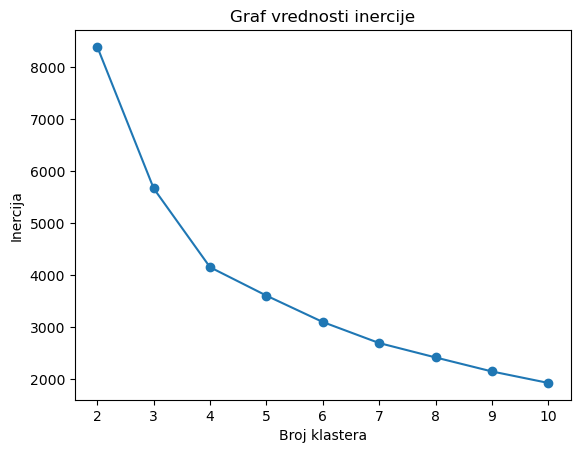

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Pravimo praznu listu za vrednosti inercije
inertia_values = []

# Pokušavamo različite brojeve klastera od 2 do 10 (možete promeniti opseg)
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(similarity_matrix)
    inertia_values.append(kmeans.inertia_)

# Prikazujemo graf vrednosti inercije u zavisnosti od broja klastera
plt.plot(range(2, 11), inertia_values, marker='o')
plt.title('Graf vrednosti inercije')
plt.xlabel('Broj klastera')
plt.ylabel('Inercija')
plt.show()


In [52]:
from networkx.algorithms.community import girvan_newman
import itertools

comp = girvan_newman(G)

level = 3

for communities_at_level in itertools.islice(comp, level, None):
    dendrogram = list(sorted(c) for c in communities_at_level)
    print("Dendrogram komuna na nivou", level)
    print(dendrogram)

plt.legend()
plt.show()

KeyboardInterrupt: 

In [74]:
from sklearn.cluster import SpectralClustering

# Spektralno klasterisanje
spectral_clustering = SpectralClustering(n_clusters=5, affinity='precomputed_nearest_neighbors')
cluster_labels = spectral_clustering.fit_predict(similarity_matrix)

# Rezultati klasterisanja
print("Rezultati klasterisanja:")
print(cluster_labels)
print(len(cluster_labels))

file_name = "rezultati_klasterisanja.txt"

with open(file_name, "w") as file:
    for label in cluster_labels:
        file.write(f"{label}\n")

Rezultati klasterisanja:
[1 1 1 ... 3 3 3]
3124


In [75]:
import folium
import pandas as pd

stopsPath = "../Desktop/asmPodaci/stops.txt"
data = pd.read_csv(stopsPath)
stop_ids_to_remove = [1243, 1245, 1247, 3735, 3737, 3757]
data = data[~data['stop_id'].isin(stop_ids_to_remove)]
data['cluster_label'] = cluster_labels
#print(data)

m = folium.Map(location=[data['stop_lat'].mean(), data['stop_lon'].mean()], zoom_start=13)

cluster_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4']

for index, row in data.iterrows():
    label = row['cluster_label']
    color = cluster_colors[label]
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=row['stop_name']
    ).add_to(m)

m.save("Lmreza_mapa.html")